In [1]:
from mltoolbox.basic import *

In [2]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [3]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path

In [5]:
import math, os

In [6]:
PATH = Path("data/train_spectograms/")
len(list(PATH.iterdir()))

10168

In [7]:
im = Image.open(PATH/'1.jpg')

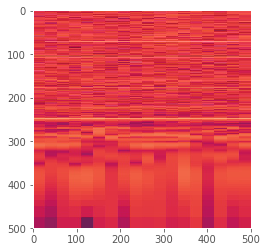

In [8]:
plt.imshow(np.asarray(im))
plt.grid(False)

In [7]:
sz=500

In [8]:
from mltoolbox.image import stats_dict

In [9]:
df = folder2df(fpath=PATH)

In [10]:
df['signal_id'] = df.fname.apply(lambda x: int(str(x).split('/')[-1].split('.')[0]))

In [13]:
df.head()

,fname,label,signal_id
0,data/train_spectograms/0.jpg,train_spectograms,0
1,data/train_spectograms/1.jpg,train_spectograms,1
2,data/train_spectograms/10.jpg,train_spectograms,10
3,data/train_spectograms/100.jpg,train_spectograms,100
4,data/train_spectograms/1000.jpg,train_spectograms,1000


In [11]:
train_meta = pd.read_csv('data/metadata_train.csv')

In [15]:
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [12]:
df = df.join(train_meta, on=['signal_id'], how='left', lsuffix='_l'
             )[['fname', 'signal_id', 'id_measurement', 'phase', 'target']]

In [13]:
df.head()

,fname,signal_id,id_measurement,phase,target
0,data/train_spectograms/0.jpg,0,0,0,0
1,data/train_spectograms/1.jpg,1,0,1,0
2,data/train_spectograms/10.jpg,10,3,1,0
3,data/train_spectograms/100.jpg,100,33,1,0
4,data/train_spectograms/1000.jpg,1000,333,1,0


In [13]:
from mltoolbox.plotting import *

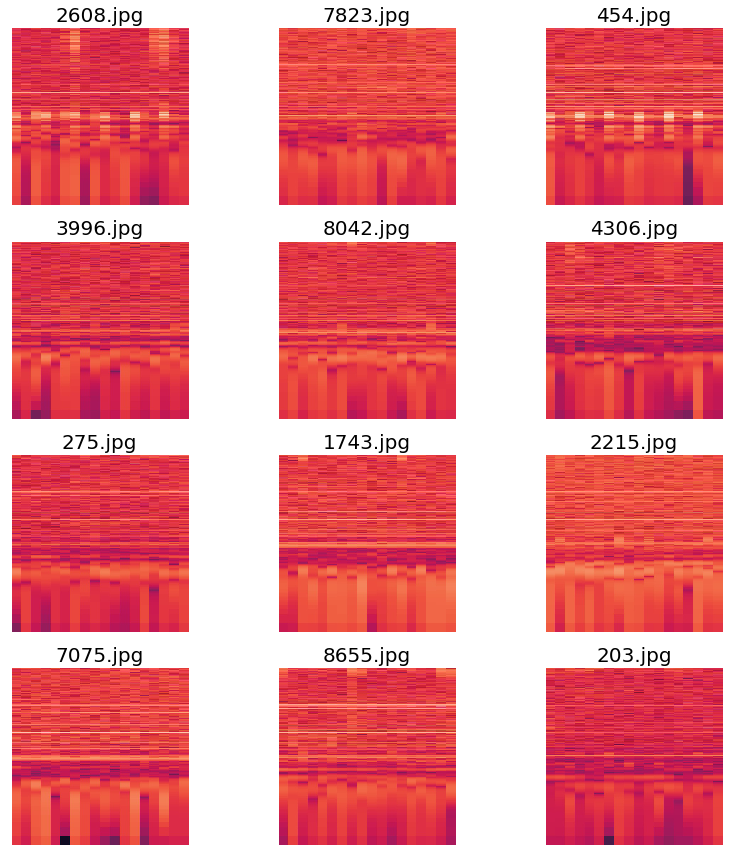

In [19]:
multi_plot(df.fname.apply(lambda x: str(x)).sample(n=12).values)

In [14]:
train, valid = split_df(df)

In [21]:
train.target.value_counts()

0    6590
1     400
Name: target, dtype: int64

In [15]:
train = balance_dataset(train, target_col='target', alpha=0.2)

In [16]:
train.target.value_counts()

0.0    6576
1.0    1696
Name: target, dtype: int64

In [22]:
valid.target.value_counts()

0    1597
1     125
Name: target, dtype: int64

In [14]:
from mltoolbox.image import *

In [72]:
class SpectrogramDataset(Dataset):
    def __init__(self, df, is_valid=False, is_test=True):
        self.num_files = df.shape[0]
        self.file_path = df.fname.values
        if not is_test:
            self.labels = df.target.values
        self.is_valid = is_valid
        self.is_test = is_test
        self.id = df.signal_id

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        if not self.is_test:
            y = self.labels[idx]
        else:
            y = self.id[idx]
        fpath = str(self.file_path[idx])
        x = imread_fast(fpath)
        if not self.is_valid:
            x = hcyclic_shift(x, alpha=0.9, no_blocks=18)
        x = im_int2float(x)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [19]:
train_ds = SpectrogramDataset(train)
valid_ds = SpectrogramDataset(valid, is_valid=True)

In [26]:
len(train_ds)

8190

In [27]:
len(valid_ds)

1722

In [28]:
x, y = train_ds[900]
x.shape, y

((3, 500, 500), 0)

# Note
While next-iter num_workers low is good, but while actual training num_workers high is good.

In [20]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [31]:
len(train_dl)

110

In [16]:
resnet = models.resnet34(pretrained=True)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [18]:
model = Net().cuda()

In [31]:
x, y = next(iter(valid_dl))

In [38]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 500, 500])

In [39]:
y.shape

torch.Size([64])

In [40]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 16, 16])

In [41]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [42]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [43]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [44]:
y

tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [45]:
y_hat.squeeze().detach().cpu() > 0

tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=torch.uint8)

In [19]:
from mltoolbox.dl import *

In [20]:
loss_criteria = F.binary_cross_entropy_with_logits

In [25]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [36]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

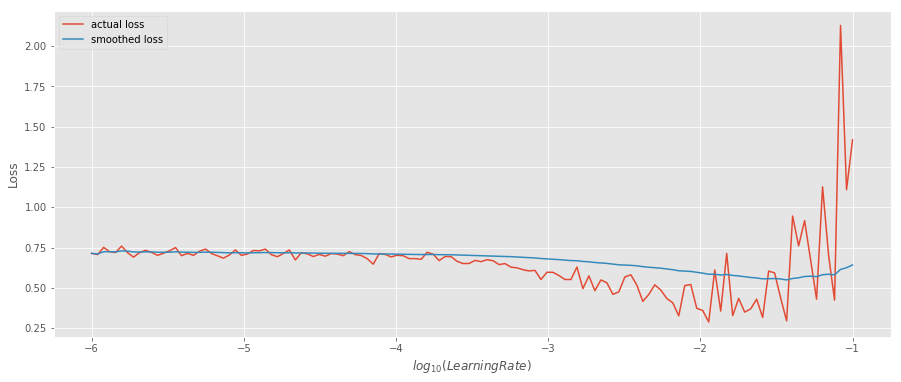

In [37]:
plot_lr(log_lrs, losses, smooth_losses)

In [27]:
best_lr = 10**(-2)
best_lr

0.01

In [28]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

model = Net().cuda()

In [21]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

In [64]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.6984992174044442,
 'accuracy_score': 0.21777003484320556,
 'matthews_corrcoef': 0.08112642282722642}

In [42]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.01, epochs=3)

Epoch No.:1, Train loss: 0.4460, val_loss: 0.2109, accuracy_score: 0.9164, matthews_corrcoef: 0.2772, 
Epoch No.:2, Train loss: 0.3591, val_loss: 0.2259, accuracy_score: 0.9158, matthews_corrcoef: 0.3815, 
Epoch No.:3, Train loss: 0.3176, val_loss: 0.2316, accuracy_score: 0.9053, matthews_corrcoef: 0.3580, 
train_triangular_policy 674.97 s


In [43]:
save_model(model, 'models/frozen.mdl')

In [30]:
load_model(model, 'models/frozen.mdl')

In [31]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.21285953773369495,
 'accuracy_score': 0.9105691056910569,
 'matthews_corrcoef': 0.4046909620705409}

In [22]:
from mltoolbox.dl import set_trainable_attr, unfreeze

In [33]:
unfreeze(model, 7)

Since more parameters are trained now need to reduce batch size to make space in GPU memory

In [34]:
model = model.cuda()

In [35]:
batch_size = 56

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [56]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

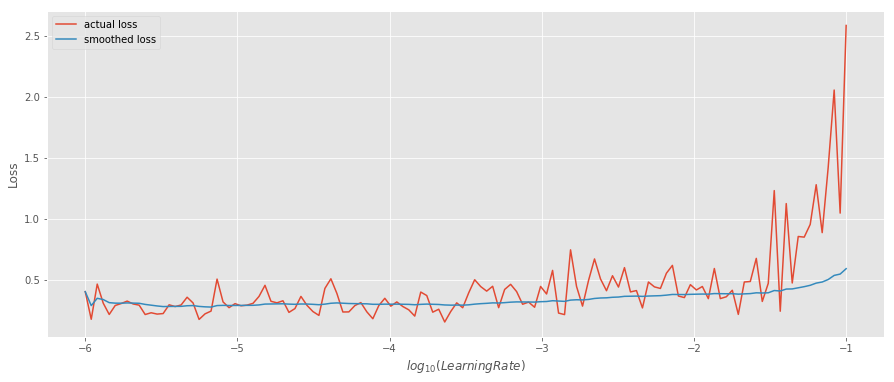

In [57]:
plot_lr(log_lrs, losses, smooth_losses)

In [36]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.2741, val_loss: 0.1340, accuracy_score: 0.9477, matthews_corrcoef: 0.6348, 
train_triangular_policy 264.15 s


In [ ]:
save_model(model, 'models/unfreeze1.mdl')

In [37]:
load_model(model, 'models/unfreeze1.mdl')

In [38]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.1569, val_loss: 0.1269, accuracy_score: 0.9483, matthews_corrcoef: 0.6318, 
train_triangular_policy 266.64 s


In [39]:
save_model(model, 'models/unfreeze2.mdl')

In [32]:
load_model(model, 'models/unfreeze2.mdl')

In [33]:
unfreeze(model, 6)

In [34]:
batch_size = 48

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [35]:
model = model.cuda()

In [36]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.2018, val_loss: 0.1051, accuracy_score: 0.9547, matthews_corrcoef: 0.6941, 
train_triangular_policy 207.77 s


In [38]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.1176, val_loss: 0.1048, accuracy_score: 0.9599, matthews_corrcoef: 0.6970, 
train_triangular_policy 204.30 s


In [41]:
save_model(model, 'models/unfreeze3.mdl')

In [89]:
load_model(model, 'models/unfreeze2.mdl')

In [40]:
y_pred, y_true = predict(model, valid_dl, is_valid=True)

In [23]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_matrix(y_true=y_true, y_pred=y_pred)

array([[1562,   35],
       [  41,   84]])

In [24]:
from mltoolbox.plotting import plot_confusion_matrix

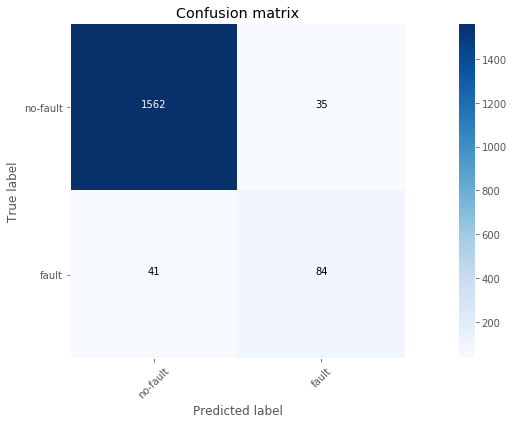

In [45]:
plot_confusion_matrix(confusion_matrix(y_true=y_true, y_pred=y_pred),
                      classes=['no-fault', 'fault'])
plt.grid()

In [46]:
matthews_corrcoef(y_pred=y_pred, y_true=y_true)

0.6650229575229362

# let's train on whole set for 2 epochs

The error and accuracy below might should not be taken seriously

In [47]:
total_ds = SpectrogramDataset(df)

In [49]:
batch_size = 48
total_dl = DataLoader(total_ds, batch_size=batch_size, shuffle=True, num_workers=8)

In [50]:
training_loop(model=model, train_dl=total_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.0981, val_loss: 0.0821, accuracy_score: 0.9698, matthews_corrcoef: 0.7521, 
train_triangular_policy 213.44 s


In [51]:
save_model(model, 'models/final1.mdl')

In [52]:
training_loop(model=model, train_dl=total_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.0739, val_loss: 0.0906, accuracy_score: 0.9669, matthews_corrcoef: 0.7247, 
train_triangular_policy 215.94 s


In [53]:
save_model(model, 'models/final2.mdl')

# predictions

In [68]:
load_model(model, 'models/final2.mdl')

In [91]:
model = model.cuda()

In [27]:
test = pd.read_csv('data/metadata_test.csv')

In [28]:
test.head()

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1


In [29]:
test.tail()

,signal_id,id_measurement,phase
20332,29044,9681,1
20333,29045,9681,2
20334,29046,9682,0
20335,29047,9682,1
20336,29048,9682,2


In [30]:
test['fname'] = test.signal_id.apply(lambda x: f"data/test_spectograms/{x}.jpg")

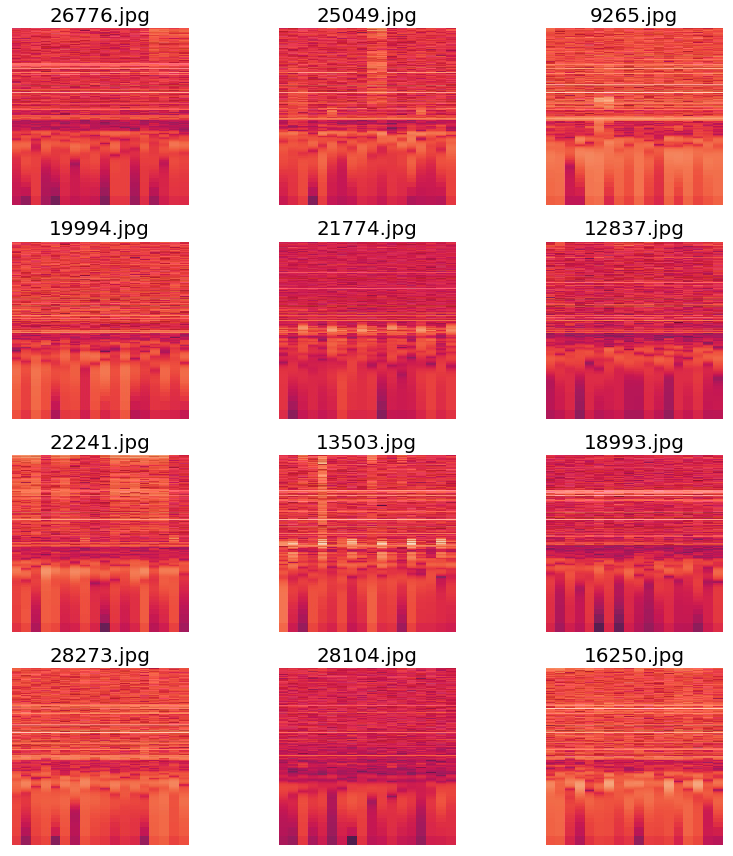

In [31]:
multi_plot(test.fname.sample(n=12).values)

In [73]:
test_ds = SpectrogramDataset(test, is_valid=True, is_test=True)

In [45]:
test.signal_id.min()

8712

In [46]:
test.signal_id.max()

29048

In [34]:
for i in progress_bar(range(8712, 29049)):
    try:
        im = imread_fast(f'data/test_spectograms/{i}.jpg')
    except:
        print(i)

In [90]:
batch_size = 64

test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=8)

In [92]:
def predict(model, data_dl):
    signal_ids = []
    y_pred = []
    model.eval()
    for x, y in progress_bar(data_dl):
        x = x.float().cuda()
        out = model(x)
        y_pred.append(out.squeeze().detach().cpu() > 0)
        signal_ids.append(y.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    signal_ids = np.concatenate(signal_ids)
    
    return signal_ids, y_pred

In [93]:
signal_ids, y_pred = predict(model, test_dl)

In [94]:
signal_ids.shape

(20337,)

In [95]:
y_preds.shape

(20337,)

In [97]:
np.bincount(y_preds)

array([20255,    82])

In [98]:
! head data/sample_submission.csv

signal_id,target
8712,0
8713,0
8714,0
8715,0
8716,0
8717,0
8718,0
8719,0
8720,0


In [99]:
test.signal_id.values.shape

(20337,)

In [100]:
result = np.vstack([signal_ids, y_preds])

In [102]:
result = result.transpose()

In [103]:
result

array([[ 8712,     0],
       [ 8713,     0],
       [ 8714,     0],
       ...,
       [29046,     0],
       [29047,     0],
       [29048,     0]])

In [104]:
with open('final3.csv', 'wb') as f:
    f.write(b'signal_id,target\n')
    np.savetxt(f, result, fmt='%i', delimiter=",")

In [105]:
! head final3.csv

signal_id,target
8712,0
8713,0
8714,0
8715,0
8716,0
8717,0
8718,0
8719,0
8720,0


In [66]:
!pwd

/home/jupyter/self/VSBPowerLineFaultDetection
